# Producing virtual datacube catalogs for ITS_LIVE granules

This notebook will describe a general overview of the process used to design and build the catalogs of kerchunk references for the ITS_LIVE velocity granules.

## Data Preparation
We will use one year of Sentinel-1 (2020), which contains 96,800 granules. Note that the granule urls are pre-sorted along a spatial index (in this case, geohash tiles), this is a crucial pre-requisite and will be discussed in more detail later on. 

In [1]:
import json
import geopandas as gpd
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm
from gen_refs import process_granules

urls = Path("data/urls.txt").read_text().split("\n")
batch_size = 100
nbatches = len(urls) // batch_size

Note: Running the below cell takes about a day on a 1 Gbps home internet connection.

In [ ]:
for i in tqdm(range(nbatches)):
    start = i*100
    end = (i+1)*100
    data = process_granules(urls[start:end])
    Path(f"refs_json/{i}.json").write_text(json.dumps(data))

## Catalog Structure
The catalog *mostly* is compliant with the [GeoParquet specification](https://github.com/stac-utils/stac-geoparquet/blob/main/spec/stac-geoparquet-spec.md), where most rows correspond to individual STAC items representing each image pair granule. This was chosen to help lay the groundwork for representing the ITS_LIVE data inside STAC catalogs, and making granules searchable by metadata values would be useful for generating virtual datacubes on the fly. 

There is no official community standard for embedding kerchunk references inside of a STAC item. [xstac](https://github.com/stac-utils/stac-geoparquet/blob/main/spec/stac-geoparquet-spec.md) has one possible implementation in which individual pieces of the references are split into different columns, but the catalogs generated here just use a single column for the entire kerchunk JSON blobs of each granule. This is probably not the most optimal choice, and some further consideration should be made about how to avoid duplicate storage of metadata inside the STAC item and kerchunk reference data. However this approach has the benefit of simplicity and avoids additional overhead of having to piece the references data back into a form that can be used as an fsspec reference filesystem. 

Below we will generate a sample catalog of the ~100k 2020 S1 granules, first opening the references we generated and converting them to STAC items:

In [2]:
from gran_to_cat import refs_to_stac_item
import stac_geoparquet

items = []
refs = []
for i in tqdm(range(nbatches)):
    refs_ = list(json.loads(Path(f"refs_json/{i}.json").read_text()).values())
    items_ = [refs_to_stac_item(r) for r in refs_]
    for r, item in zip(refs_, items_):
        refs.append(json.dumps(r).encode())
        # Note that when saving the STAC Geoparquet with the assets, the file size explodes and
        # arrow ends up expanding them into excessive columns. This means our catalog effectively
        # no longer contains true STAC items but for our current purposes they aren't needed. 
        # This should be fixed at some point since we want the references to eventually coexist
        # with an actual STAC catalog.
        del item["assets"]
        items.append(item)

  0%|          | 0/968 [00:00<?, ?it/s]

To create the initial STAC GeoParquet catalog:

In [3]:
table = stac_geoparquet.arrow.parse_stac_items_to_arrow(items)

ITS_LIVE archives granules generated from multiple satellites (Landsat, Sentinel 1 & 2) and a complete catalog would span tens of millions of granules. The total size of the raw kerchunk reference data alone could easily reach dozens of gigabytes in size, therefore the catalog needs to support some form of random access which avoids the need to load the entire thing into memory before a query gets processed. The parquet format supports this via *partitions* (datasets spanned by multiple parquet files), and individual files can be subdivided further into smaller logical chunks of data called *row groups*. 

Because our data has space and time dimensions, we may so choose to partition into either spatial or temporal bins. Optimally partitioning the catalog is the most challenging part of this process because the data is not uniformly distributed in space or time, so a production ready implementation would most likely not have evenly spaced bins in the dimensions of choice. I have tested two partitioning approaches, one with simple temporal partitioning (binned by each year) and another with a more complex spatial partitioning scheme in which all granules that intersect a partition's bounding box are included. This latter approach makes it easy to pre-filter our queries by dropping partitions that do not intersect the query's bounding box, but suffers from granules needing to be duplicated across multiple partitions. As a result I currently prefer and recommend the temporal approach. However some clever pre-filtering of the data is necessary for efficient spatial queries.

Below we will save the catalog with a hive partition scheme, partitioning by year:

In [4]:
pq_file = "refs_stac_sentinel1/year=2020/refs_2020.parquet"
stac_geoparquet.arrow.to_parquet(
    table, 
    pq_file, 
    compression="ZSTD", write_statistics=False
)

## Optimizing Spatial Queries
Queries to the catalog will require a set of spatial bounds, but having the data grouped by temporal bins alone is not sufficient for optimal queries. Ideally, the rows of the catalog should include data that are close to each other in both time and space, so the entries also need to be sorted along a spatial index, and potentially subdivided further into separate blocks. There are many methods that can be used to spatially sort the data, but here I choose to use simple geohashing to presort all data in an individual partition, then split the data further into individual row groups of 1000. Generally larger row group sizes (at least 10000) are recommended, but this number was chosen for now because the S1 data used in this example resulted in a smaller number of geohash tiles in each row group.

Now we will proceed to add the kerchunk references to the catalog and save it with a row group size of 1000. The data for this were already sorted along geohash precision 2 tiles. In principle, we could sort the data *after* generating the catalog, but this is highly inefficient. Ideally, it would be best to determine the boundaries of each spatial partition / tile in advance, then find the URLs of each granule whose center lat/lons are contained in them via an existing database search. Then the URLs can be individually cataloged in the process shown above and then combined into a single parquet file per temporal partition.

In [5]:
df = gpd.read_parquet(pq_file)
df["kerchunk"] = refs
df["attrs"] = [json.loads(json.loads(r)["refs"][".zattrs"]) for r in refs]
rg_size = 1000
df.to_parquet(
    pq_file, 
    compression="ZSTD", 
    row_group_size=rg_size, 
    write_statistics=["datetime"]
)

## Prefiltering
Previously we discribed how to subdivide the catalog into small manageable chunks that represent data that are close together in space. Most parquet reading tools support a form of prefiltering data based on partition and row group statistics (called predicate pushdown), however these libraries cannot natively apply spatial filters (eg intersection and contains operations on bounding boxes). Instead, we need to do this ourselves manually. The virtual_cubes.py code expects the catalog to contain not only the partitioned STAC GeoParquet catalog, but also a separate `.row_groups.parquet` table. The rows in this table correspond to the row group indices, and the values are the merged geometry of all granules contained in the row group. Then querying the catalog involves two steps: Determining which partitions and row group indices to load based on the provided time range and bounding box, and then applying filtering (potentially based on metadata values).

The process for generating this row groups geometry table is implemented as follows. First, we will load the geometries for all of the granules in the dataset in one go. To do this in the most efficient way we can open the partitioned dataset from the top level directory to read all partitions at once. Currently in this example we have just one partition, but this will extend seamlessly once the data is fully populated with all parititions.

In [7]:
geoms = gpd.read_parquet("refs_stac_sentinel1/", columns=["geometry", "year"])

Since we know that all row_groups have a fixed size of 1000, we can now assign unique groups to all of the granules based on the relative row group index in the partition, and the partition label (year in this case).

In [8]:
year = np.array(geoms.year)
rg_index = geoms.index // rg_size
geoms["index"] = rg_index
gb = geoms.groupby(by=["year", "index"])

/var/folders/xp/q52ryy9976x7d4b9w9q8tpr9ptwmb3/T/ipykernel_71548/3477267058.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gb = geoms.groupby(by=["year", "index"])


Finally we merge all the geometries of each group together, this gives us another GeoParquet table which has the complete polygon domain for all granules in a row group.

In [10]:
rg_geoms = gb.aggregate(lambda x: x.geometry.unary_union).reset_index()
# Make row group indices relative to each paritition rather than entire dataset.
offsets = rg_geoms.groupby("year").apply(lambda x: x["index"].min())
rg_index_adj = rg_geoms.set_index("year")["index"] - offsets
rg_geoms["index"] = rg_index_adj.values
rg_geoms.to_parquet(
    "refs_stac_sentinel1/.row_groups.parquet", 
    compression="ZSTD",
    write_statistics=False
)

/var/folders/xp/q52ryy9976x7d4b9w9q8tpr9ptwmb3/T/ipykernel_71548/2900963401.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  offsets = rg_geoms.groupby("year").apply(lambda x: x["index"].min())
/var/folders/xp/q52ryy9976x7d4b9w9q8tpr9ptwmb3/T/ipykernel_71548/2900963401.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  offsets = rg_geoms.groupby("year").apply(lambda x: x["index"].min())


To illustrate how this works, we can plot the row group boundaries:

<Axes: >

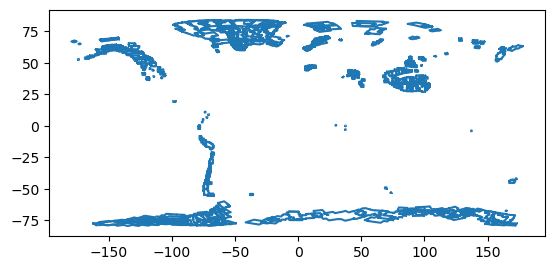

In [14]:
rg_geoms.set_geometry("geometry").boundary.plot()

This completes the production process for one year's worth of S1 granules, and may be repeated for the rest. 